<a href="https://colab.research.google.com/github/rybread1/deep_image/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL

import IPython.display as display
import numpy as np
import time
import functools

In [ ]:
style_path = '/content/FAA_starrry_night.jpg'
content_path = '/content/fresh-flowers-1550252718.jpg'

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def _load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor+1, input_tensor-1)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


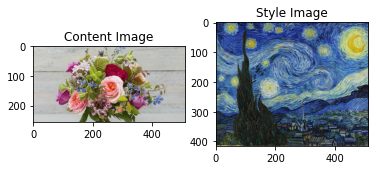

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('vase', 0.2758836),
 ('pot', 0.23367603),
 ('handkerchief', 0.18362409),
 ('picket_fence', 0.04767609),
 ('birdhouse', 0.02609643)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)



input_14
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 415, 512, 64)
  min:  0.0
  max:  696.2169
  mean:  24.927261

block2_conv1
  shape:  (1, 207, 256, 128)
  min:  0.0
  max:  3024.8745
  mean:  151.21072

block3_conv1
  shape:  (1, 103, 128, 256)
  min:  0.0
  max:  6593.093
  mean:  151.57053

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  14231.104
  mean:  561.0564

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3638.9065
  mean:  47.22186



In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.1430226
    max:  43296.0
    mean:  492.50616

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  121035.836
    mean:  17458.195

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  808611.06
    mean:  18617.133

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7711674.0
    mean:  231860.02

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  120673.34
    mean:  1723.4766

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  1186.9656
    mean:  15.281113


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
style_weight=1
content_weight=100


def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers


    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
total_variation_weight=0.01

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))



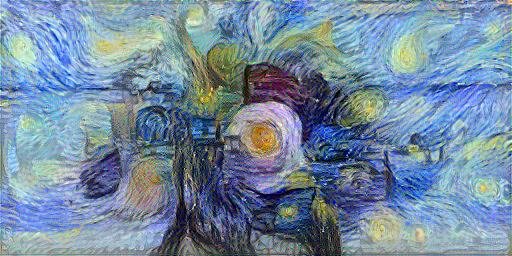

Train step: 2000


In [ ]:
image = tf.Variable(content_image)

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))


In [ ]:
!git clone https://github.com/rybread1/deep_image.git

Cloning into 'deep_image'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (377/377), done.
remote: Total 421 (delta 49), reused 372 (delta 28), pack-reused 0
Receiving objects: 100% (421/421), 5.76 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
import importlib
from deep_image import histogram_loss
from deep_image import style_transfer
importlib.reload(style_transfer)
importlib.reload(histogram_loss)

<module 'deep_image.histogram_loss' from '/content/deep_image/histogram_loss.py'>

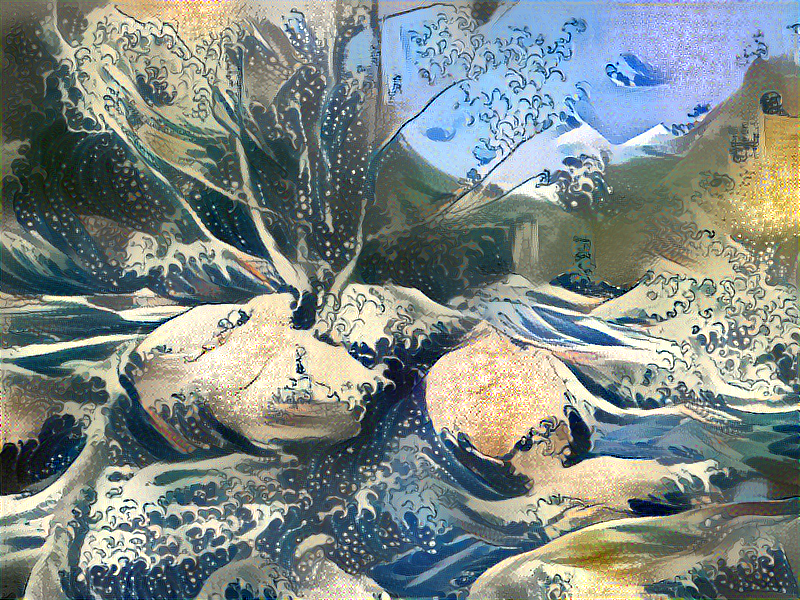

Train step: 5000


In [ ]:
style_transfer.style_transfer(style_path='/content/wave.jpg', 
                              content_path='/content/river.jpg',
                              style_weight=1000,
                              content_weight=1,
                              learning_rate=0.0005,
                              total_variation_weight=0.001,
                              epochs=50,
                              steps_per_epoch=100,
                              content_grey=False,
                              style_grey=False,
                              max_dim=800,
                              save_folder='/content/forest')

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import IPython.display as display
import numpy as np
import os
from deep_image.histogram_loss import hist_match, hist_loss

In [ ]:
def _gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor[:,2:,2:,:], input_tensor[:,:-2,:-2,:])
    input_shape = tf.shape(input_tensor[:,2:,2:,:])
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

    # result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    # input_shape = tf.shape(input_tensor)
    # num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    # return result / num_locations

def _vgg_layers(layer_names, avg_pool=False):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    if avg_pool:
      vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
      vgg.trainable = False

      layers = vgg.layers

      x = layers[0].output
      for i in range(1, len(layers)):
        if i in [3, 6, 11, 16, 21]:
          x = tf.keras.layers.AveragePooling2D()(x)
        else:
          x = layers[i](x)

      vgg_new = tf.keras.Model(inputs=[layers[0].input], outputs=x)

      layer_names = style_layers + content_layers
      outputs = [vgg_new.get_layer(name).get_output_at(1) for name in layer_names]
      model = tf.keras.Model([vgg_new.input], outputs)
      return model
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model


def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def _tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


def _load_img(path_to_img, max_dim, grey=False):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    if grey:
        img = tf.image.rgb_to_grayscale(img)
        img = tf.squeeze(tf.stack([img, img, img], axis=2))
        
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
    if not isinstance(image, PIL.Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = PIL.Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)


def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, average_pool=False):
        super(StyleContentModel, self).__init__()
        self.vgg = _vgg_layers(style_layers + content_layers, average_pool)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [_gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}




In [ ]:
style_image = _load_img('/content/wave.jpg', 500, grey=False)
content_image = _load_img('/content/river.jpg', 500, grey=False)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block4_conv1']

num_style_layers = len(style_layers)

inputs = style_image * 255.0
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
vgg = _vgg_layers(style_layers + content_layers, True)
outputs = vgg(preprocessed_input)

style_outputs, content_outputs = (outputs[:num_style_layers],
                                  outputs[num_style_layers:])



In [ ]:
style_path='/content/Fantasy-Wonderland-5D-DIY-Round-Diamond-Embroidery-Diamond-Painting-Cross-Stitch-Diamond-Mosaic-Needlework-Home-Decor.jpg'
content_path='/content/river.jpg'
style_weight=0.01
content_weight=1
learning_rate=0.05
total_variation_weight=0.01
epochs=20
steps_per_epoch=100
content_grey=False
style_grey=False
max_dim=500
save_folder='/content/baseline'

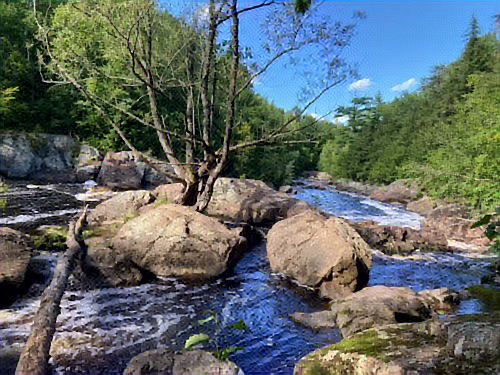

Train step: 2000


In [ ]:
content_image = _load_img(content_path,max_dim, grey=content_grey)
style_image = _load_img(style_path, max_dim, grey=style_grey)

content_layers = ['block4_conv1']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers, average_pool=True)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)

def style_content_loss(outputs, image):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # histogram_loss = (hist_loss(content_outputs['block4_conv1'], style_targets['block4_conv1'])) * 0.00001
    style_weights = dict(zip(style_layers, [1.0, 0.8, 0.5, 0.2, 0.2]))

    losses = []
    for name in style_outputs.keys():
      if name == 'block1_conv1' or name == 'block4_conv1':
        conv1_loss = tf.reduce_mean((tf.math.abs((style_outputs[name] - style_targets[name]))) * style_weights[name]) + (total_variation_weight * (tf.image.total_variation(image)))
        losses.append(tf.squeeze(conv1_loss))
      else:
        losses.append((tf.reduce_mean(tf.math.abs((style_outputs[name] - style_targets[name])))) * style_weights[name])
  
    style_loss = tf.add_n(losses)
    style_loss *= style_weight / num_style_layers

    
    #style_weights = dict(zip(style_layers, [1.0, 1.0, 1.0, 1.0, 1.0]))

    # style_loss = tf.add_n([tf.reduce_mean(tf.math.abs((style_outputs[name] - style_targets[name]))) * style_weights[name]
    #                   for name in style_outputs.keys()])
    # style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.math.abs((content_outputs[name] - content_targets[name])))
                              for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss, content_loss, style_loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss, content_loss, style_loss = style_content_loss(outputs, image)
        # loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss, content_loss, style_loss



image = tf.Variable(content_image)
# for i in range(200):
#   grad, loss, tvw, outputs = train_step(image)
#   print(loss)


step = 0
losses = []
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss, content_loss, style_loss = train_step(image)

        if m % 20 == 0:
          print('content loss:', content_loss, 'style loss:', style_loss)
        losses.append(loss)
        print(".", end='')

    if save_folder:
        save_image(_tensor_to_image(image), os.path.join(save_folder, f'epoch-{n}'))
    display.clear_output(wait=True)
    display.display(_tensor_to_image(image))
    print("Train step: {}".format(step))

tf.Tensor(26359.344, shape=(), dtype=float32)


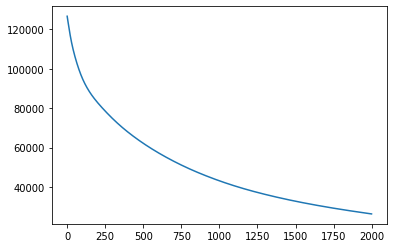

In [ ]:
  plt.plot(losses)
  print(min(losses))